In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/docker_current/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Читаем данные

In [97]:
data_df = pd.read_csv("dataset_with_descriptionds.csv", usecols=["hotel_id", "downloaded", "description"])
data_df = data_df[data_df["downloaded"] == True]
data_df.head()

,hotel_id,downloaded,description
0,104555,True,"there is a bathroom with a sink, mirror, and s..."
1,104555,True,there is a bed with a white sheet and two lamp...
2,104555,True,there is a bathroom with a mirror and a sink i...
3,104555,True,"arafed bedroom with a bed, chair, and lamp in ..."
4,104555,True,there are two beds in a hotel room with a chai...


# Лемматизируем

In [118]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text, max_words=14):
    text = text.replace(",", "")
    words = text.split(" ")
    words = words[0:max_words]
    # print(words)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

In [119]:
data_df["lemmatize_desc"] = data_df["description"].apply(lambda x: lemmatize_text(x))

In [120]:
data_df.head()

,hotel_id,downloaded,description,lemmatize_desc
0,104555,True,"there is a bathroom with a sink, mirror, and s...",there is a bathroom with a sink mirror and sho...
1,104555,True,there is a bed with a white sheet and two lamp...,there is a bed with a white sheet and two lamp...
2,104555,True,there is a bathroom with a mirror and a sink i...,there is a bathroom with a mirror and a sink i...
3,104555,True,"arafed bedroom with a bed, chair, and lamp in ...",arafed bedroom with a bed chair and lamp in it...
4,104555,True,there are two beds in a hotel room with a chai...,there are two bed in a hotel room with a chair...


In [121]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_df["lemmatize_desc"])
# Преобразуйте матрицу TF-IDF в DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Применяем SVD

In [126]:
svd = TruncatedSVD(n_components=50)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Подбираем число кластеров "методом локтя"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

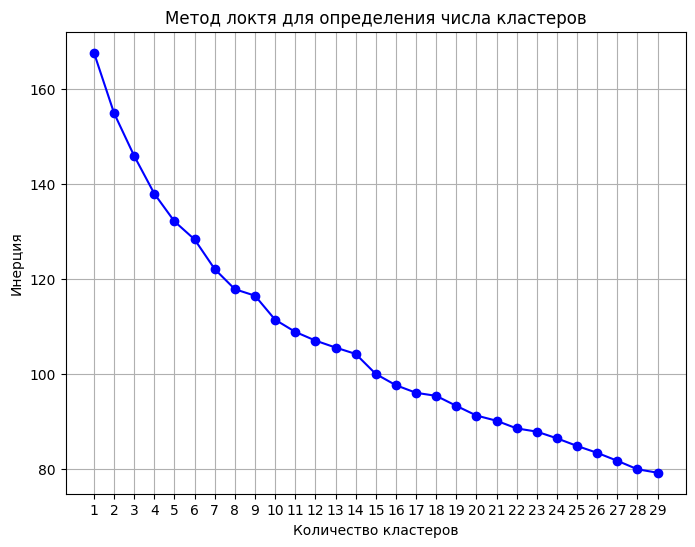

In [129]:
inertia = []

n = 30

for k in range(1, n):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_reduced)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(range(1, n), inertia, marker='o', linestyle='-', color='b')
plt.title('Метод локтя для определения числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.xticks(np.arange(1, n, 1))
plt.grid(True)
plt.show()

### Значение в 9-10 кластеров можно взять за оптимальное, поскольку после них график спадает с меньшей резкостью

In [139]:
# Предсказания для оптимального числа кластеров
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(tfidf_reduced)
results = kmeans.predict(tfidf_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Визуализируем

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import pandas as pd

In [140]:
# Понижаем размерность, чтобы можно было визуализировать
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tfidf_embedded = tsne.fit_transform(tfidf_reduced)

In [160]:
text_list = data_df["lemmatize_desc"]
df = pd.DataFrame({'x': tfidf_embedded[:, 0], 'y': tfidf_embedded[:, 1], 'cluster': results, 'text': text_list})
palette = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'grey', 'black', 'cyan']
cluster_colors = [palette[i % len(palette)] for i in results]
df['cluster_colors'] = cluster_colors

source = ColumnDataSource(df)


p = figure(title="Кластеры текстов")

p.scatter(x='x', y='y', size=8, source=source, legend_field='cluster', color="cluster_colors")

hover = HoverTool()
hover.tooltips = [("Текст", "@text"), ("Кластер", "@cluster")]
p.add_tools(hover)

# p.legend.title = 'Кластер'
# p.legend.label_text_font_size = '10pt'

output_notebook()   
show(p)

Loading BokehJS ...

### Из визуализации понятно, что данные хорошо сгруппировались в кластеры. Однако вместо группировки по отелям, они сформировались группами по различнам типам помещений (ванная, спальная ..). Это логично, исходя из тех текстовых описаний, которые используются для обучения модели.